La arquitectura del LLM en la figura consta de varios bloques de construcción. Comenzaremos con una vista general de la arquitectura del modelo antes de abordar los componentes individuales con más detalle.


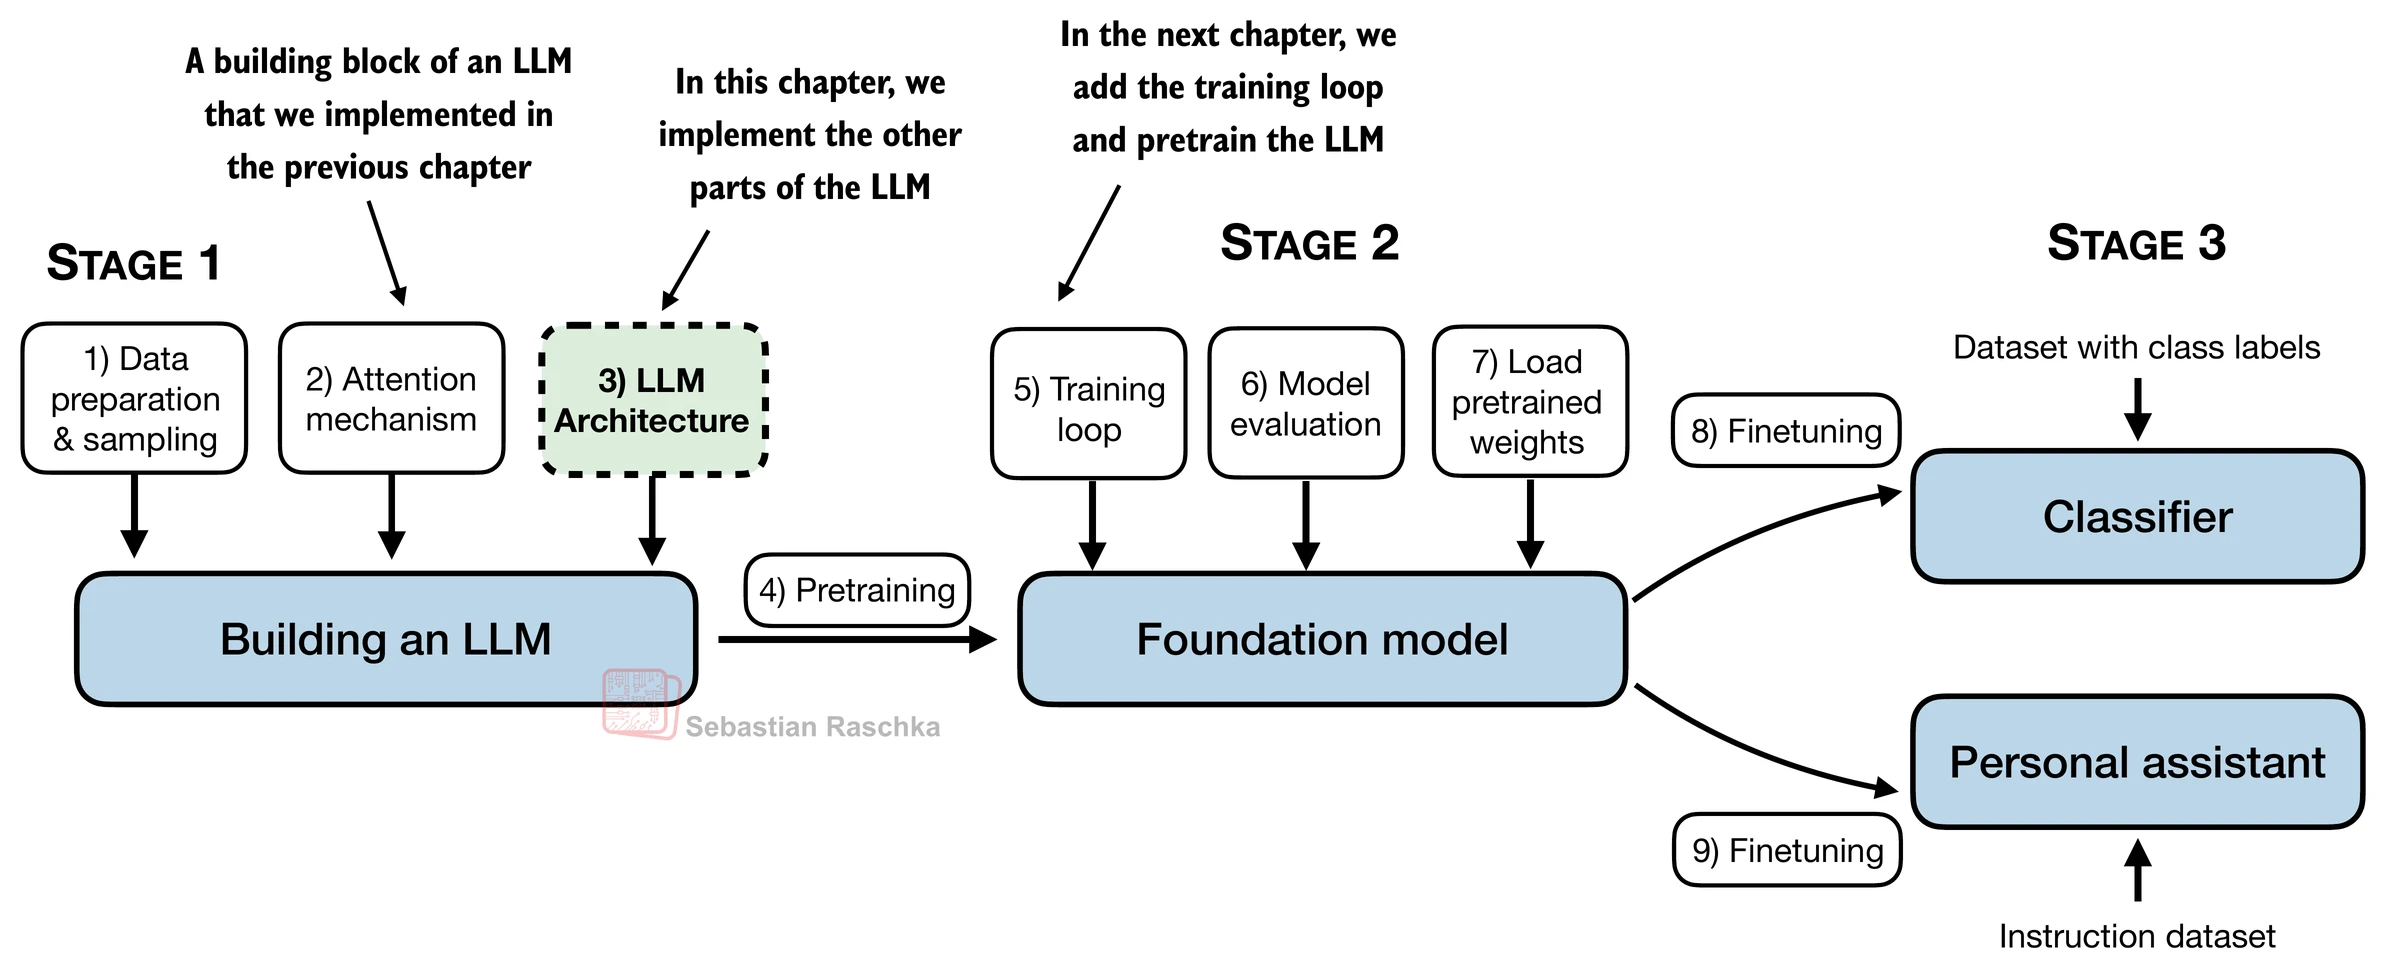

**4.1 Programando una arquitectura de LLM**

El capítulo 1 abordó modelos como GPT y Llama, que generan palabras de forma secuencial y están basados en la parte del decodificador de la arquitectura original del transformer.
Por lo tanto, estos LLM suelen denominarse "LLM tipo decodificador".
En comparación con los modelos convencionales de aprendizaje profundo, los LLM son más grandes, principalmente debido a su enorme cantidad de parámetros, no por la cantidad de código.
Veremos que muchos elementos se repiten dentro de la arquitectura de un LLM.

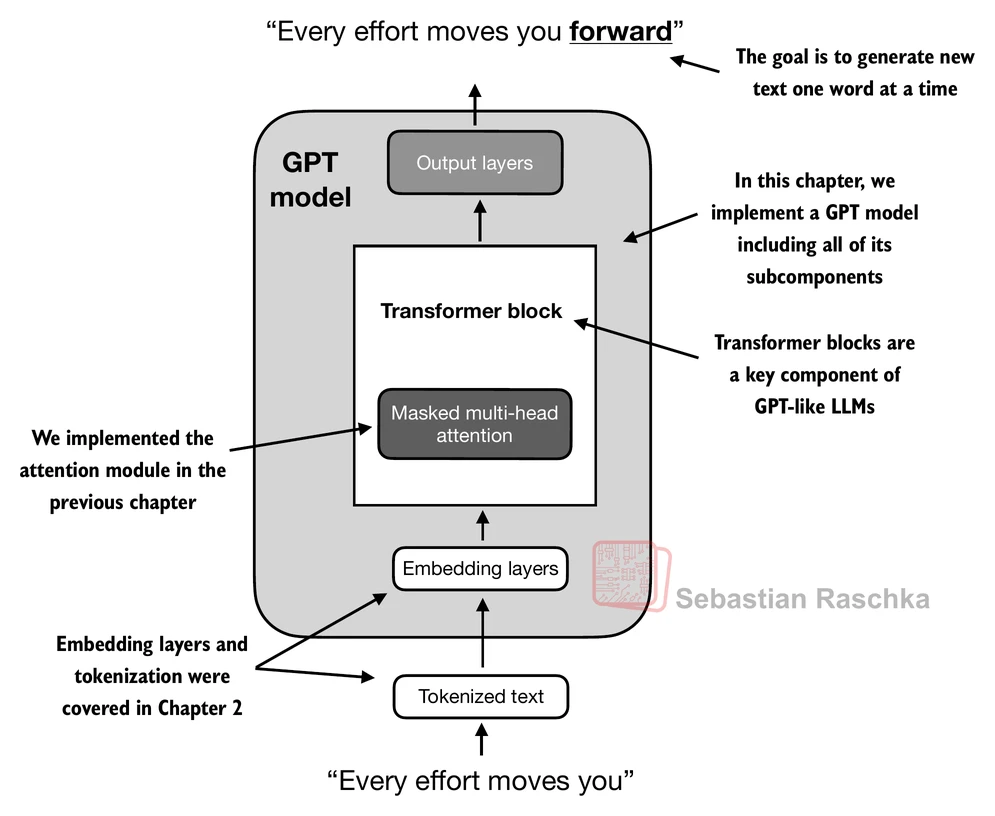

In [106]:
from importlib.metadata import version
print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.10.0
torch version: 2.9.0+cpu
tiktoken version: 0.12.0


In [36]:
"""
 vocab_size se refiere a un vocabulario de 50,257 palabras, como el que utiliza el tokenizador BPE (ver capítulo 2).
 context_length indica el número máximo de tokens de entrada que el modelo puede manejar mediante los embeddings posicionales (ver capítulo 2).
 emb_dim representa el tamaño del embedding, transformando cada token en un vector de 768 dimensiones.
 n_heads indica la cantidad de cabezas de atención en el mecanismo de atención multi-cabeza (ver capítulo 3).
 n_layers especifica el número de bloques de transformador en el modelo, los cuales abordaremos en la siguiente discusión.
 drop_rate indica la intensidad del mecanismo de dropout (0.1 implica una eliminación aleatoria del 10% de las unidades ocultas) para prevenir el sobreajuste (ver capítulo 3).
 qkv_bias determina si se debe incluir un vector de sesgo en las capas lineales de la atención multi-cabeza para los cálculos de consulta (query), clave (key) y valor (value).
 Inicialmente lo desactivaremos, siguiendo las normas de los LLM modernos, pero lo retomaremos en el capítulo 6 cuando carguemos los pesos preentrenados de GPT-2 desde OpenAI en nuestro modelo (ver capítulo 6).

"""
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}



In [38]:
"""
Una clase de arquitectura de modelo GPT provisional, Dummy-GPT Model
"""

import torch
import torch.nn as nn


class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [43]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [44]:
"""
El tensor de salida tiene dos filas que corresponden a las dos muestras de texto.
Cada muestra de texto consta de cuatro tokens; cada token es un vector de 50.257 dimensiones,
lo que coincide con el tamaño del vocabulario del tokenizador.
"""

torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print('Output shape: ', logits.shape)
print(logits)



Output shape:  torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


### 4.2 Normalización de activaciones con normalización de capa

Entrenar redes neuronales profundas con muchas capas puede resultar desafiante debido a problemas como los gradientes que desaparecen o los gradientes que explotan. Estos problemas conducen a dinámicas de entrenamiento inestables y dificultan que la red ajuste eficazmente sus pesos, lo que significa que el proceso de aprendizaje lucha por encontrar un conjunto de parámetros (pesos) para la red neuronal que minimice la función de pérdida. En otras palabras, la red tiene dificultades para aprender los patrones subyacentes en los datos hasta un grado que le permita hacer predicciones o decisiones precisas.


*  La normalización de capa, también conocida como LayerNorm, centra las activaciones de una capa de red neuronal alrededor de una media de 0 y normaliza su varianza a 1.
* Esto estabiliza el entrenamiento y permite una convergencia más rápida hacia pesos efectivos.
* La normalización de capa se aplica tanto antes como después del módulo de atención multi-cabeza dentro del bloque transformador, el cual implementaremos más adelante; también se aplica antes de la capa de salida final.

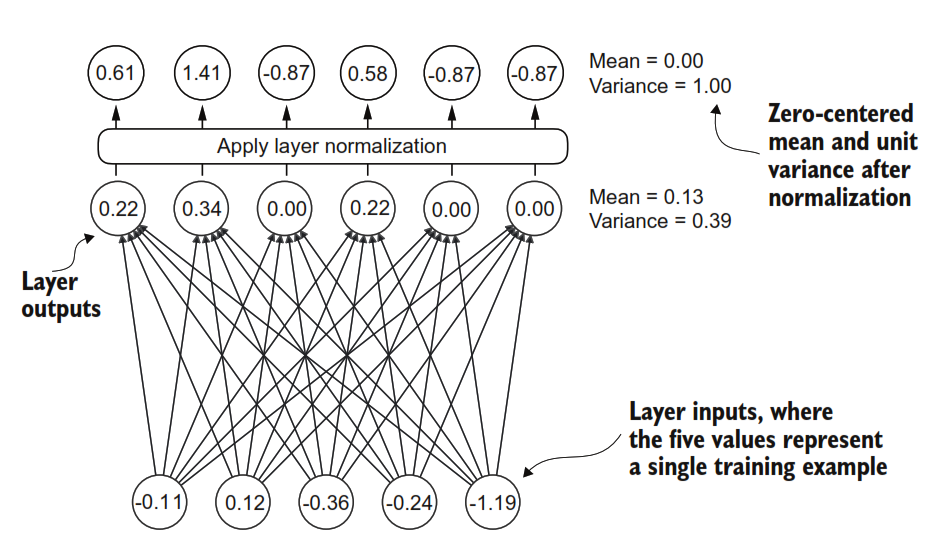







In [45]:
torch.manual_seed(123)
# Crea dos ejemplos de entrenamiento con cinco dimensiones (características) cada uno
batch_example = torch.rand(2, 5)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())
out = layer(batch_example)
print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [46]:
mean = out.mean(dim=-1,keepdim=True)
var = out.var(dim=-1, keepdim=True)
print("Media: \n", mean)              # La media mide el valor promedio de las activaciones de salida.
print("Variancia: \n", var)           # La varianza mide cuánto se dispersan esos valores alrededor de la media.


Media: 
 tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
Variancia: 
 tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


Usar keepdim=True en operaciones como el cálculo de la media o la varianza asegura que el tensor de salida conserve el mismo número de dimensiones que el tensor de entrada, aunque la operación reduzca el tensor a lo largo de la dimensión especificada mediante dim.
Por ejemplo, sin keepdim=True, el tensor de la media devuelto sería un vector bidimensional [0.1324,0.2170] en lugar de una matriz de dimensiones 2\times 1 [[0.1324],[0.2170]].

El parámetro dim especifica la dimensión a lo largo de la cual debe realizarse el cálculo de la estadística (en este caso, la media o la varianza) dentro de un tensor.

para un tensor bidimensional (como una matriz), usar dim=-1 en operaciones como el cálculo de la media o la varianza es equivalente a usar dim=1. Esto se debe a que -1 hace referencia a la última dimensión del tensor, que en un tensor bidimensional corresponde a las columnas. Al añadir la normalización por capas al modelo GPT, que produce tensores tridimensionales con la forma [batch\_ size,num\_ tokens,embedding\_ size], aún podemos usar dim=-1 para normalizar a lo largo de la última dimensión, evitando tener que cambiar de dim=1 a dim=2.




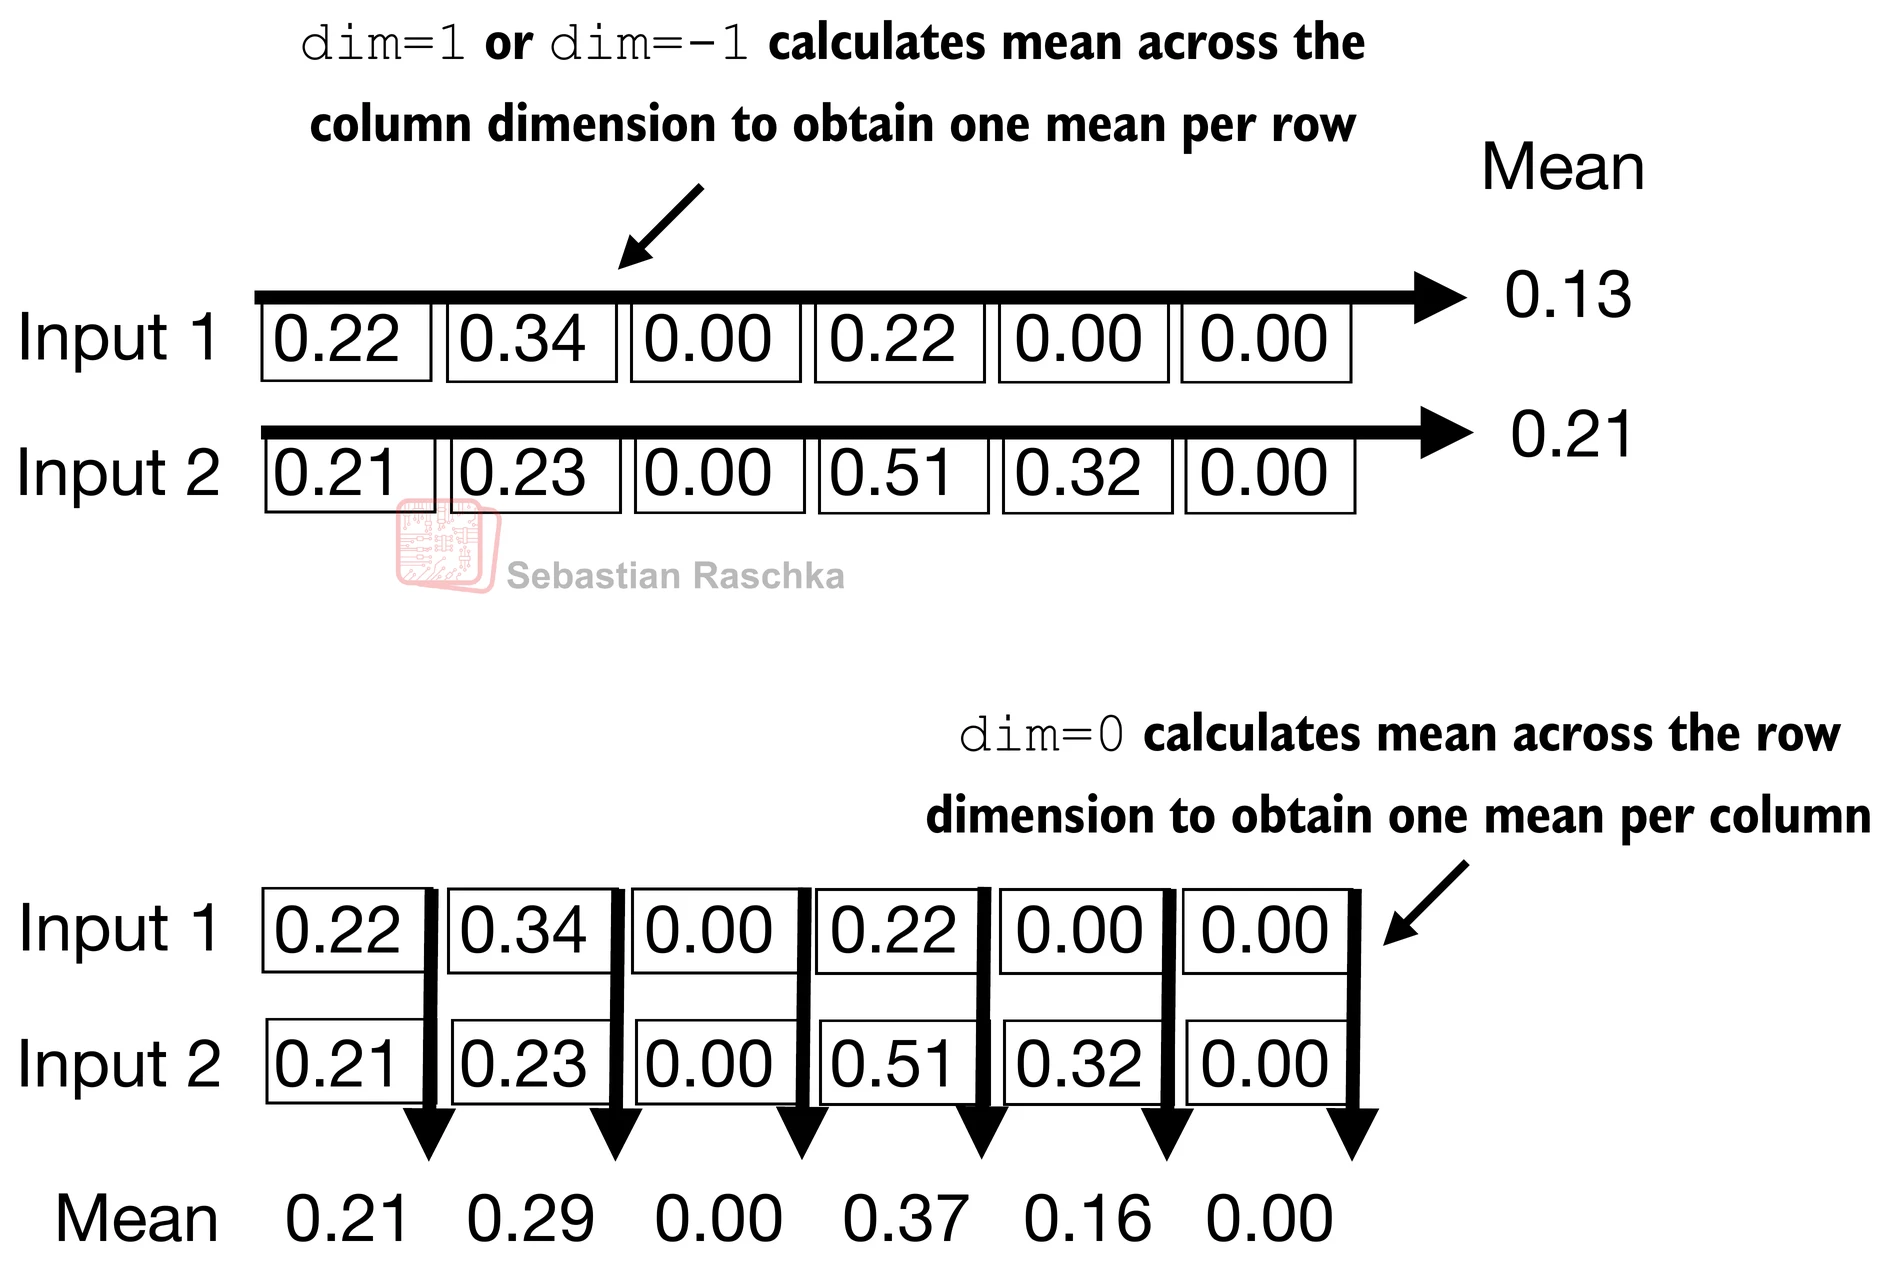

In [47]:
"""
A continuación, apliquemos la normalización por capas (layer normalization) a las
salidas de capa que obtuvimos anteriormente. La operación consiste en restar la
media y dividir por la raíz cuadrada de la varianza (también conocida como
la desviación estándar.
"""

out_norm = (out -mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Salidas de la capa normaliada:\n", out_norm)
print('------------------------------------------------')
print('Media (mean): \n', mean)
print('------------------------------------------------')
print('Varianza (variance): \n', var)

Salidas de la capa normaliada:
 tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
------------------------------------------------
Media (mean): 
 tensor([[ 0.0000],
        [-0.0000]], grad_fn=<MeanBackward1>)
------------------------------------------------
Varianza (variance): 
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [ ]:
# mejorando la legibilidad
torch.set_printoptions(sci_mode=False)
print('Media (mean): \n', mean)
print('------------------------------------------------')
print('Varianza (variance): \n', var)

Media (mean): 
 tensor([[ 0.0000],
        [-0.0000]], grad_fn=<MeanBackward1>)
------------------------------------------------
Varianza (variance): 
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [48]:
# encapsulcion de este proceso en modulo de Pytorch que ulizaremos despues en el mdoelo GPT
"""
La normalización por capas (layer normalization) opera sobre la última dimensión del tensor de entrada x,
que representa la dimensión de incrustación (embedding dimension, emb_dim). La variable eps es una pequeña constante (epsilon)
que se añade a la varianza para evitar la división por cero durante la normalización.
Los parámetros scale y shift son dos parámetros entrenables
(de la misma dimensión que la entrada) que el LLM ajusta automáticamente durante el
entrenamiento si se determina que hacerlo mejora el rendimiento del modelo en su tarea de entrenamiento.
Esto permite que el modelo aprenda un escalado y un desplazamiento apropiados que se
adapten mejor a los datos que está procesando.
"""
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean = x.mean(dim=-1, keepdim=True)
    var = x.var(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x-mean)/ torch.sqrt(var+self.eps)
    return self.scale*norm_x+self.shift

In [49]:
# LayerNorm modulo en la practica
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print('Media (mean): \n', mean)
print('------------------------------------------------')
print('Varianza (variance): \n', var)

Media (mean): 
 tensor([[ 0.0000],
        [-0.0000]], grad_fn=<MeanBackward1>)
------------------------------------------------
Varianza (variance): 
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


Normalización por capas vs. normalización por lotes
la normalización por lotes (batch normalization), un método común y tradicional de normalización en redes neuronales, quizá te preguntes cómo se compara con la normalización por capas (layer normalization).
A diferencia de la normalización por lotes, que normaliza a lo largo de la dimensión del lote, la normalización por capas normaliza a lo largo de la dimensión de las características. Los LLMs suelen requerir recursos computacionales significativos, y el hardware disponible o el caso de uso específico pueden dictar el tamaño del lote durante el entrenamiento o la inferencia.
Dado que la normalización por capas normaliza cada entrada de manera independiente del tamaño del lote, ofrece mayor flexibilidad y estabilidad en estos escenarios. Esto resulta particularmente beneficioso para el entrenamiento distribuido o al desplegar modelos en entornos donde los recursos están limitados.



### 4.3 Implementación de una red feed-forward con activaciones GELU.


Históricamente, la función de activación ReLU ha sido comúnmente utilizada en el aprendizaje profundo debido a su simplicidad y efectividad en diversas arquitecturas de redes neuronales. Sin embargo, en los LLMs se emplean varias otras funciones de activación más allá de la tradicional ReLU. Dos ejemplos notables son GELU (Gaussian Error Linear Unit) y SwiGLU (Swish-Gated Linear Unit). GELU y SwiGLU son funciones de activación más complejas y suaves que incorporan unidades lineales gaussianas y unidades lineales con compuerta sigmoide, respectivamente. Estas ofrecen un mejor rendimiento para modelos de aprendizaje profundo, a diferencia de la más simple ReLU.
La función de activación GELU puede implementarse de varias maneras; la versión exacta se define como:

$\mathrm{GELU}(x)=x\cdot \Phi (x)$

donde $\Phi (x)$ es la función de distribución acumulativa de la distribución gaussiana estándar. En la práctica, sin embargo, es común implementar una aproximación computacionalmente más barata (el modelo original GPT-2 también fue entrenado con esta aproximación, la cual se obtuvo mediante ajuste de curvas).


In [109]:
import math

class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(
            math.sqrt(2.0 / math.pi) * (x + 0.044715 * x**3)
        ))
# class GELU(nn.Module):
#   def __init__(self):
#     super().__init__()

#   def forward(self,x):
#     return 0.5*x*(1 + torch.tanh(
#         torch.sqrt(torch.tensor(2.0/torch.pi) *
#          (x + 0.044715 * torch.pow(x, 3)))
#     ))

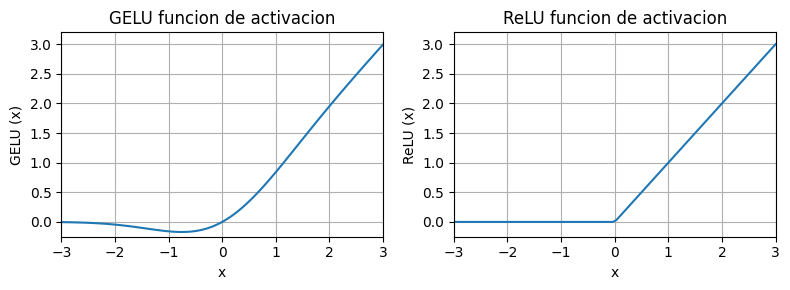

In [110]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)      # Crea 100 muestras de datas en el rango de -3 a 3
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
  plt.subplot(1, 2, i)
  plt.plot(x, y)
  plt.title(f"{label} funcion de activacion")
  plt.xlabel("x")
  plt.ylabel(f"{label} (x)")
  plt.grid(True)
  plt.xlim(-3, 3)
  plt.ylim(-0.25, 3.2)
plt.tight_layout()
plt.show()

### Continuando lo que dice el libro

In [111]:
# Un modulo feed forward  de una red neuronal
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
        GELU(),
        nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
    )

  def forward(self,x):
    return self.layers(x)


In [112]:
print(GPT_CONFIG_124M["emb_dim"])

768


hbhvj,v

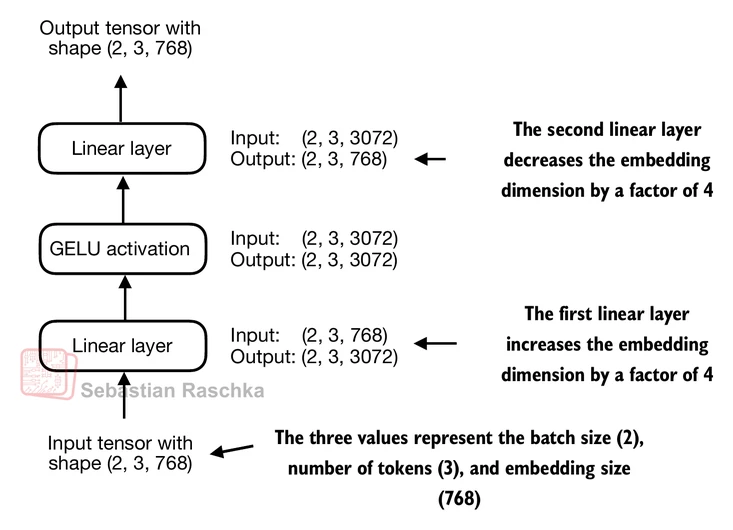

In [113]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)           # crea una entrada de dimension de lote igual 2
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


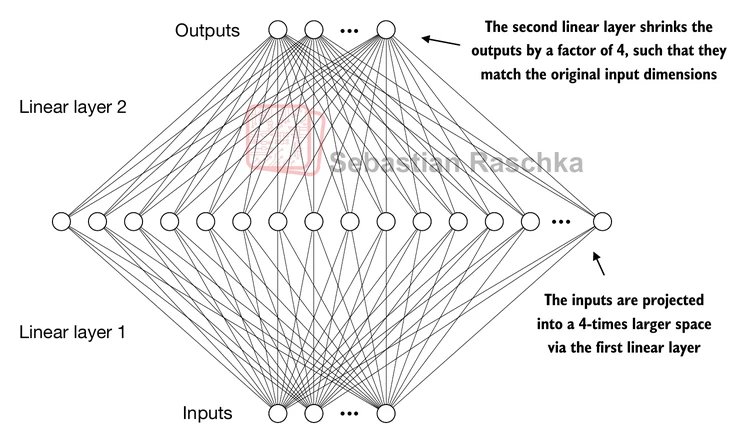

### 4.4  Añadiendo conexiones de atajo
también conocidas como skip connections o conexiones residuales. Originalmente, las conexiones de atajo fueron propuestas para redes profundas en visión por computadora (específicamente, en las redes residuales) con el fin de mitigar el desafío del gradiente desvanecido. El problema del gradiente desvanecido se refiere a la situación en la que los gradientes (que guían las actualizaciones de los pesos durante el entrenamiento) se vuelven progresivamente más pequeños a medida que se propagan hacia atrás a través de las capas, lo que dificulta entrenar de manera efectiva las capas más tempranas.

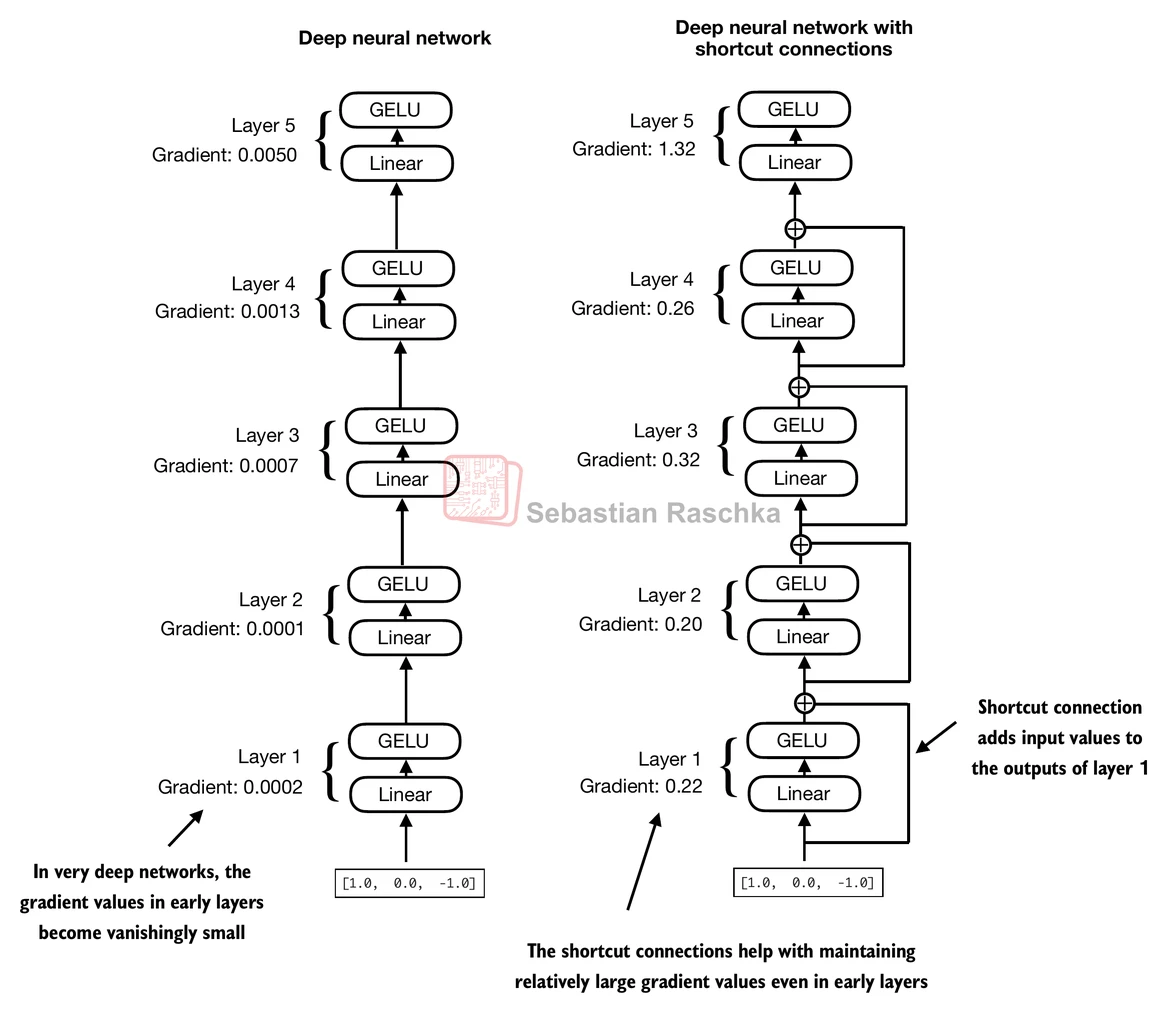


In [114]:
# Una red neuronal para ilustrar la conexión de atajo
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]),
                          GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]),
                          GELU())
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


# class ExampleDeepNeuralNetwork(nn.Module):
#   def __init__(self, layer_sizes, use_shortcut):
#     super().__init__()
#     self.use_shortcut = use_shortcut
#     self.layers = nn.ModuleList([
#         nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
#         nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
#         nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
#         nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
#         nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
#     ])

#   def forward(self, x):
#     for layer in self.layers:
#       layer_output = layer(x)                                     # Calcular la salida de la capa actual
#       if self.use_shortcut and x.shape == layer_output.shape:     # Verificar si se puede aplicar la conexión de atajo
#         x = x + layer_output
#       else:
#         x = layer_output
#     return x

#     # implemnatacion de una función que calcule los gradientes en el paso hacia atrás (backward pass) del modelo




In [115]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)

# layer_sizes = [3, 3, 3, 3, 3, 1]
# sample_input = torch.tensor([[1., 0., -1.]])
# torch.manual_seed(123)                          # Especifica la semilla aleatoria para los pesos iniciales con el fin de garantizar la reproducibilidad
# model_without_shortcut = ExampleDeepNeuralNetwork(
#     layer_sizes, use_shortcut=False
# )

In [116]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])
    loss = nn.MSELoss()
    loss = loss(output, target)
    loss.backward()

    for name, param in model.named_parameters():
      if 'weight' in name:
          print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

# def print_gradients(model, x):
#   output = model(x)                      # Paso hacia adelante (Forward pass)
#   target = torch.tensor([[0.]])

#   loss = nn.MSELoss()
#   loss = loss(output, target)            # Calcula la pérdida en función de qué tan cerca están el objetivo y la salida
#   loss.backward()                        # Paso hacia atrás (Backward pass) para calcular los gradientes

#   for name, param in model.named_parameters():
#     if "weight" in name:
#       print(f"{name} tiene media de gradiente de : {param.grad.abs().mean().item()}")



In [117]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


El código implementa una red neuronal profunda con cinco capas, cada una compuesta por una capa Linear y una función de activación GELU. En el paso hacia adelante (forward pass), pasamos iterativamente la entrada a través de las capas y, opcionalmente, añadimos las conexiones de atajo si el atributo self.use_shortcut está configurado en True.
Usemos este código para inicializar una red neuronal sin conexiones de atajo.
Cada capa se inicializará de tal manera que acepte un ejemplo con tres valores de entrada y devuelva tres valores de salida. La última capa devuelve un único valor de salida.


In [119]:
# implemnatacion de una función que calcule los gradientes en el paso hacia atrás (backward pass) del modelo

def print_gradients(model, x):
  output = model(x)                      # Paso hacia adelante (Forward pass)
  target = torch.tensor([[0.]])

  loss = nn.MSELoss()
  loss = loss(output, target)            # Calcula la pérdida en función de qué tan cerca están el objetivo y la salida
  loss.backward()                        # Paso hacia atrás (Backward pass) para calcular los gradientes

  for name, param in model.named_parameters():
    if "weight" in name:
      print(f"{name} tiene media de gradiente de : {param.grad.abs().mean().item()}")

print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight tiene media de gradiente de : 0.000605207693297416
layers.1.0.weight tiene media de gradiente de : 0.00036033481592312455
layers.2.0.weight tiene media de gradiente de : 0.002145612146705389
layers.3.0.weight tiene media de gradiente de : 0.00419662008062005
layers.4.0.weight tiene media de gradiente de : 0.01514893677085638


Este código especifica una función de pérdida que calcula qué tan cerca están la salida del modelo y un objetivo definido por el usuario (aquí, para simplificar, el valor 0). Luego, al llamar a loss.backward(), PyTorch calcula el gradiente de la pérdida para cada capa del modelo.
Podemos iterar a través de los parámetros de los pesos mediante model.named_parameters(). Supongamos que tenemos una matriz de parámetros de peso de $3\times 3$ en una capa determinada. En ese caso, esta capa tendrá $3\times 3$ valores de gradiente, y podemos imprimir el gradiente absoluto medio de esos $3\times 3$ valores para obtener un único valor de gradiente por capa, lo que facilita la comparación de los gradientes entre capas.
En resumen, el método .backward() es una forma conveniente en PyTorch de calcular los gradientes de la pérdida, los cuales son necesarios durante el entrenamiento del modelo, sin tener que implementar nosotros mismos las matemáticas para el cálculo del gradiente.

La salida de la función print_gradients muestra que los gradientes se vuelven más pequeños a medida que avanzamos desde la última capa (layers.4) hasta la primera capa (layers.0), lo cual es un fenómeno llamado problema del gradiente desvanecido (vanishing gradient problem).



In [120]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=True)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight tiene media de gradiente de : 0.22169798612594604
layers.1.0.weight tiene media de gradiente de : 0.20694111287593842
layers.2.0.weight tiene media de gradiente de : 0.3289700150489807
layers.3.0.weight tiene media de gradiente de : 0.26657330989837646
layers.4.0.weight tiene media de gradiente de : 1.3258544206619263


La última capa (layers.4) todavía tiene un gradiente más grande que las demás capas. Sin embargo, el valor del gradiente se estabiliza a medida que avanzamos hacia la primera capa (layers.0) y no se reduce hasta un valor extremadamente pequeño.
En conclusión, las conexiones de atajo son importantes para superar las limitaciones que plantea el problema del gradiente desvanecido en redes neuronales profundas. Las conexiones de atajo son un bloque de construcción fundamental de modelos muy grandes como los LLMs, y ayudan a facilitar un entrenamiento más efectivo al garantizar un flujo de gradientes consistente a través de las capas cuando entrenemos el modelo GPT


El texto habla de que con shortcut connections los gradientes tienden a estabilizarse y no se reducen hasta valores casi nulos. En tus datos, aunque los gradientes sí disminuyen al ir hacia capas más tempranas, no se desvanecen por completo.
- Esto es lo que se entiende por “estabilizar”: los gradientes se mantienen en un rango útil (0.2–0.5 en tus capas iniciales), en lugar de colapsar hacia cero.
- Sin conexiones de atajo, normalmente verías valores mucho más pequeños en las primeras capas, lo que haría difícil entrenarlas.

✅ Conclusión
Tus resultados muestran justamente esa diferencia:
- El gradiente más alto está en la última capa.
- Los gradientes más bajos están en las primeras capas, pero siguen siendo suficientemente grandes para que el entrenamiento sea efectivo.
- Eso es lo que el texto describe como “estabilización”: no significa que todos los gradientes sean iguales, sino que no se reducen a valores insignificantes.
¿Quieres que te grafique estos valores en un pequeño plot de barras para visualizar mejor cómo se distribuyen los gradientes entre capas?


### 4.5 Conectando la atención y las capas lineales en un bloque transformer

implementemos el bloque transformer, un bloque fundamental de GPT y otras arquitecturas de LLM. Este bloque, que se repite una docena de veces en la arquitectura GPT-2 de 124 millones de parámetros, combina varios conceptos que hemos cubierto previamente: atención multi-cabeza, normalización de capas, dropout, capas feed-forward y activaciones GELU.


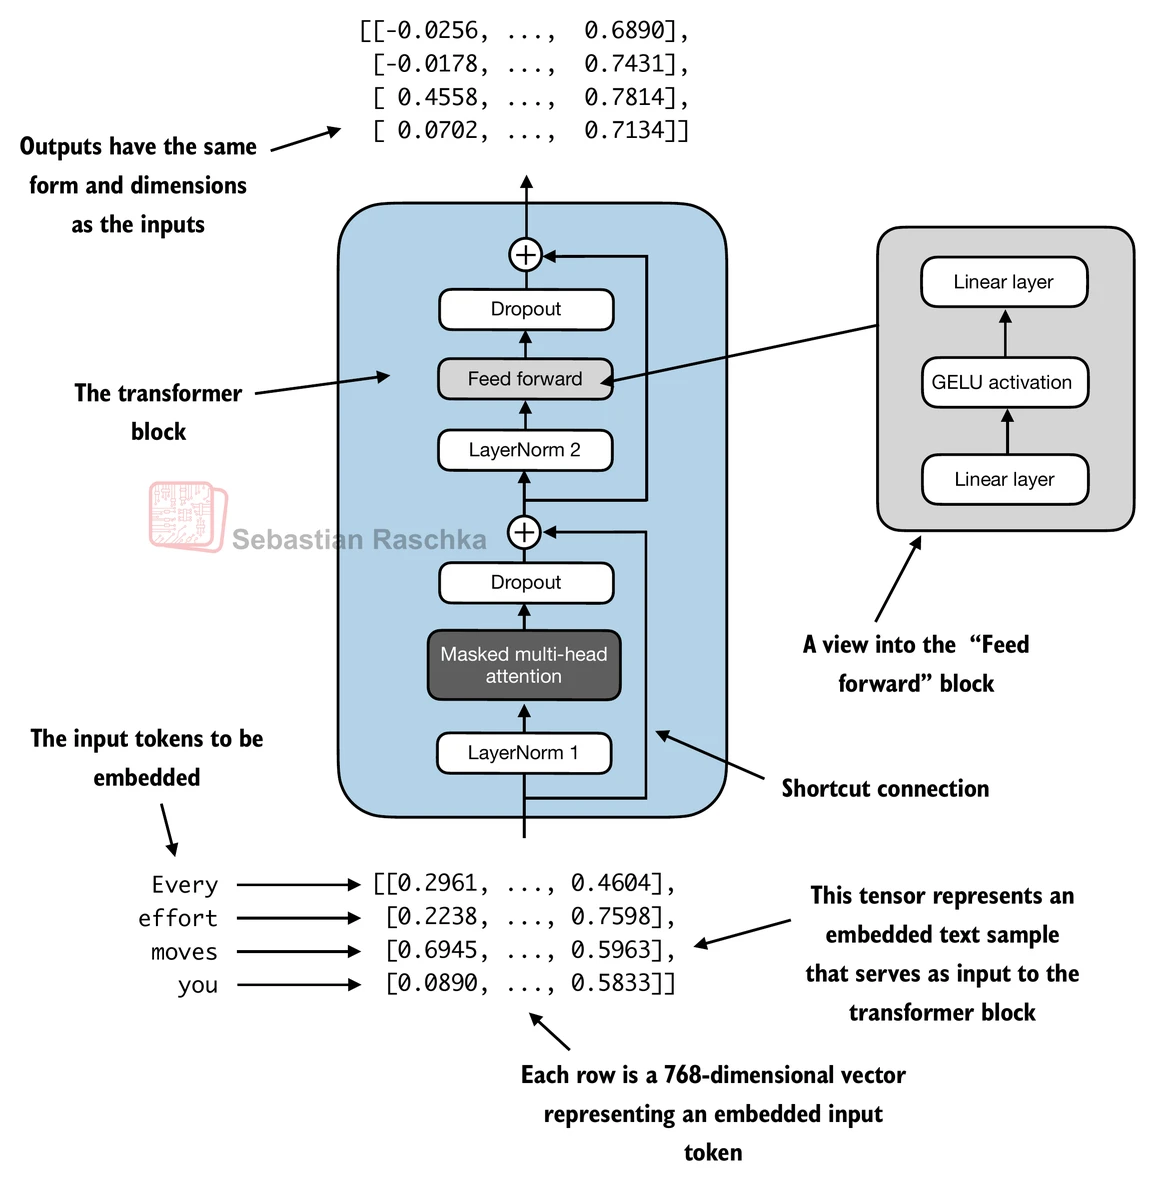



Cuando un bloque transformer procesa una secuencia de entrada, cada elemento de la secuencia (por ejemplo, una palabra o un sub-token) se representa mediante un vector de tamaño fijo (en este caso, 768 dimensiones).
Las operaciones dentro del bloque transformer, incluyendo la atención multi-cabeza y las capas feed-forward, están diseñadas para transformar estos vectores de una manera que preserve su dimensionalidad.
La idea es que el mecanismo de self-attention en el bloque de atención multi-cabeza identifique y analice las relaciones entre los elementos de la secuencia de entrada. En contraste, la red feed-forward modifica los datos de manera individual en cada posición.
Esta combinación no solo permite una comprensión y procesamiento más matizado de la entrada, sino que también mejora la capacidad general del modelo para manejar patrones de datos complejos.


In [121]:
# Código del capitulo 3

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out debe ser divisible por num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce la dimensión de proyección para que coincida con la dimensión de salida deseada

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Capa lineal para combinar las salidas de las cabezas
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        # Como en `CausalAttention`, si el número de tokens excede `context_length`,
        # esto provocará errores en la creación de la máscara más abajo.
        # En la práctica, esto no es un problema ya que el LLM (capítulos 4–7) asegura que las entradas
        # no excedan `context_length` antes de llegar a este método forward.

        keys = self.W_key(x)  # Forma: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # Dividimos implícitamente la matriz agregando una dimensión `num_heads`
        # Desenrollamos la última dimensión: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transposición: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Calculamos la atención de producto punto escalado (también conocida como autoatención) con una máscara causal
        attn_scores = queries @ keys.transpose(2, 3)  # Producto punto para cada cabeza

        # Máscara original truncada al número de tokens y convertida a booleano
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Usamos la máscara para rellenar los puntajes de atención
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Forma: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combinamos las cabezas, donde self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # proyección opcional

        return context_vec

In [122]:
# El bloque transformer en GPT es el componente fundamental

# from llms_from_scratch.ch03 import MultiHeadAttention

class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.att = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        num_heads = cfg["n_heads"],
        dropout = cfg["drop_rate"],
        qkv_bias = cfg["qkv_bias"]
    )
    self.ff = FeedForward(cfg)
    self.norm1 = LayerNorm(cfg["emb_dim"])
    self.norm2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])


  def forward(self,x):
    # Conexión de atajo para el bloque de atención
    shortcut = x
    x = self.norm1(x)
    x = self.att(x)
    x = self.drop_shortcut(x)
    x = x + shortcut          # Agregar la entrada original de nuevo


    shortcut = x              # Conexión de atajo para el bloque feed-forward
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut          # Agrega la entrada original de nuevo
    return x

In [123]:

torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)

print("Entrada Shape: ", x.shape)
print("Salida Shape: ", output.shape)

Entrada Shape:  torch.Size([2, 4, 768])
Salida Shape:  torch.Size([2, 4, 768])


el bloque transformer mantiene las dimensiones de entrada en su salida, lo que indica que la arquitectura transformer procesa secuencias de datos sin alterar su forma a lo largo de la red.
La preservación de la forma en toda la arquitectura del bloque transformer no es incidental, sino un aspecto crucial de su diseño. Este diseño permite su aplicación efectiva en una amplia gama de tareas de secuencia a secuencia, donde cada vector de salida corresponde directamente a un vector de entrada, manteniendo una relación uno a uno.


### 4.6 Codificanod un Modelo GPT

la arquitectura GPT que llamamos DummyGPTModel. En esta implementación de código de DummyGPTModel, mostramos las entradas y salidas del modelo GPT, pero sus bloques de construcción permanecían como una caja negra usando DummyTransformerBlock y la clase DummyLayerNorm como marcadores de posición.
Ahora, reemplacemos los marcadores de posición DummyTransformerBlock y DummyLayerNorm por las clases reales TransformerBlock y LayerNorm que codificamos anteriormente para ensamblar una versión completamente funcional de la versión original de GPT-2 con 124 millones de parámetros

su estructura general, el bloque transformer se repite muchas veces a lo largo de una arquitectura de GPT. En el caso del modelo GPT-2 de 124 millones de parámetros, se repite 12 veces, lo cual especificamos mediante la entrada n_layers en el diccionario GPT_CONFIG_124M. Este bloque transformer se repite 48 veces en el modelo GPT-2 más grande con 1,542 millones de parámetros.
La salida del último bloque transformer luego pasa por un paso final de normalización de capa antes de llegar a la capa lineal de salida. Esta capa mapea la salida del transformer a un espacio de alta dimensión (en este caso, 50,257 dimensiones, correspondiente al tamaño del vocabulario del modelo) para predecir el siguiente token en la secuencia.


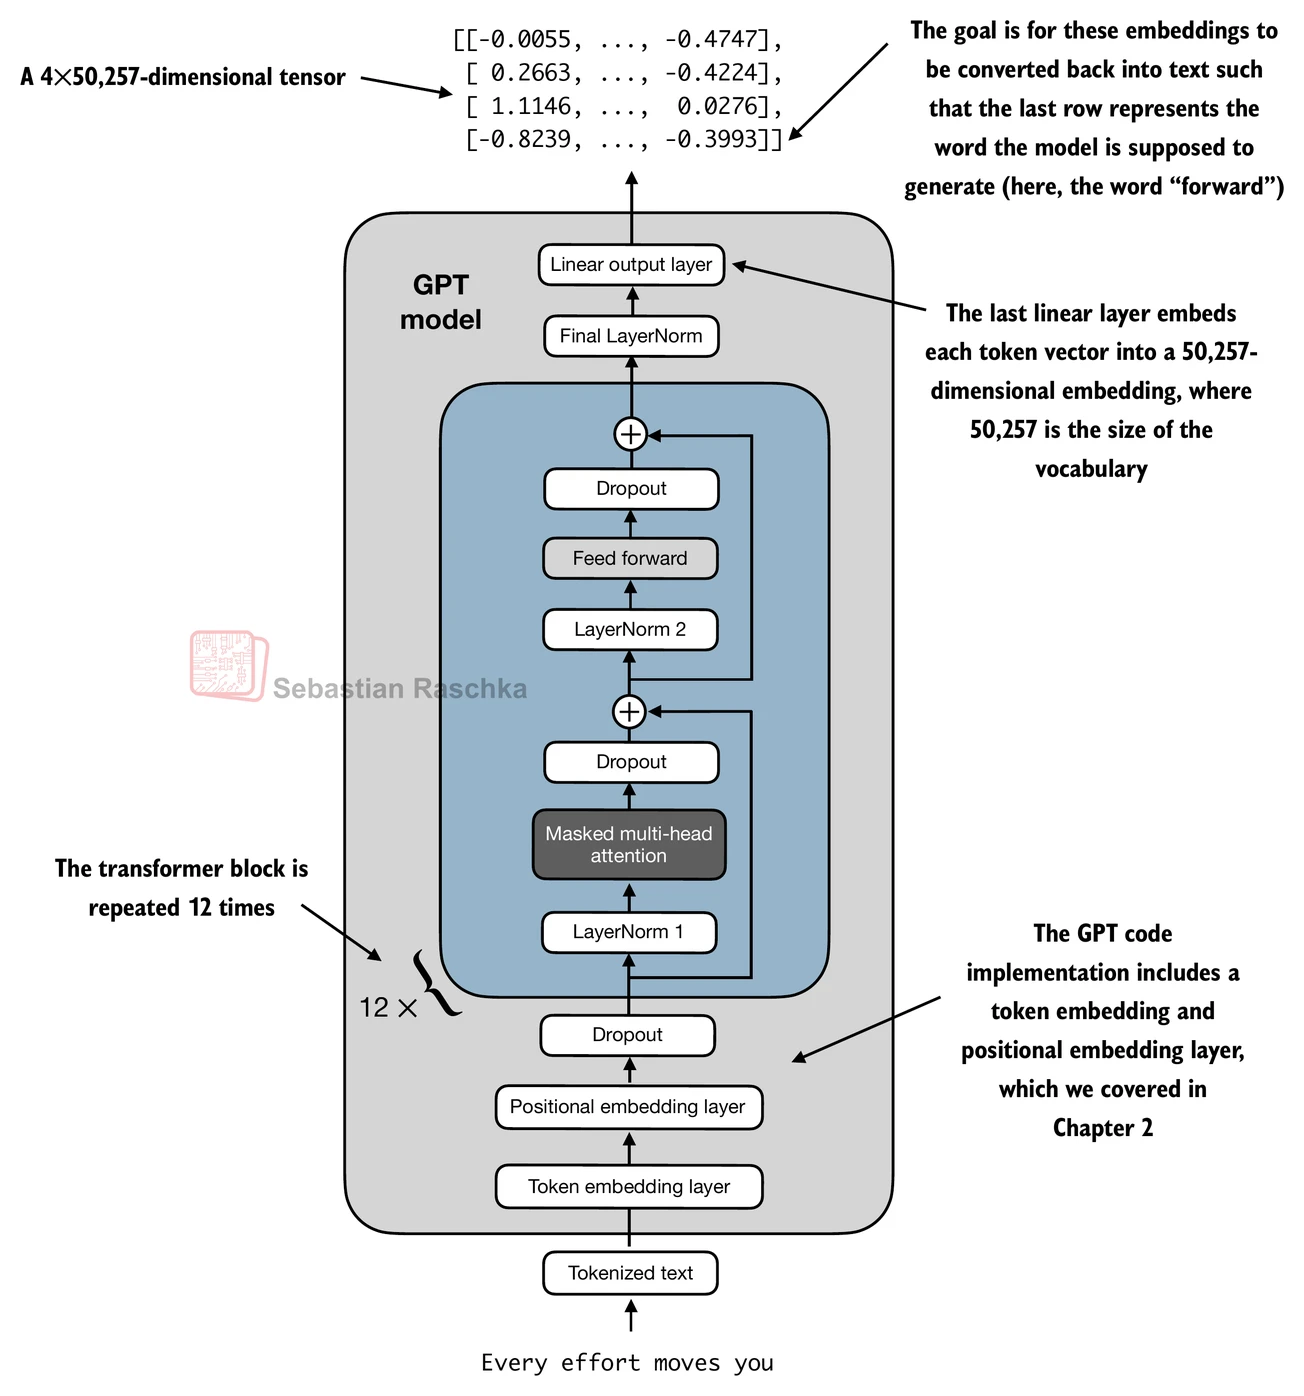

In [124]:
#Implementacion arquitectura modelo GPT

class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
    self.drop_emb = nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
    )
    self.final_norm = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"], cfg["vocab_size"], bias=False
    )

  def forward(self, in_idx):
    batch_size, seq_len = in_idx.shape
    tok_embeds = self.tok_emb(in_idx)

    pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) # La configuración del dispositivo nos permitirá entrenar el modelo en una CPU o GPU

    x = tok_embeds + pos_embeds
    x = self.drop_emb(x)
    x = self.trf_blocks(x)
    x = self.final_norm(x)
    logits = self.out_head(x)
    return logits




La clase TransformerBlock, la clase GPTModel es relativamente pequeña y compacta.
El constructor init de esta clase GPTModel inicializa las capas de token embeddings y positional embeddings utilizando las configuraciones pasadas a través de un diccionario de Python (cfg). Estas capas de embeddings son responsables de convertir los índices de los tokens de entrada en vectores densos y de añadir información posicional. A continuación, el método init crea una pila secuencial de módulos TransformerBlock igual al número de capas especificado en cfg. Después de los bloques transformer, se aplica una capa LayerNorm, que estandariza las salidas de los bloques transformer para estabilizar el proceso de aprendizaje.
Finalmente, se define una capa lineal de salida sin sesgo, que proyecta la salida del transformer en el espacio del vocabulario del tokenizer para generar logits para cada token en el vocabulario.
El método forward toma un lote de índices de tokens de entrada, calcula sus embeddings, aplica los embeddings posicionales, pasa la secuencia a través de los bloques transformer, normaliza la salida final y luego calcula los logits, que representan las probabilidades no normalizadas del siguiente token.



In [125]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch: \n", batch)
print("\nOutput shape: ", out.shape)
print(out)

Input batch: 
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape:  torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [126]:
# el metodo numel(abreviacion de número de elementos) muestra el numero de pparametos en el modelo
total_params = sum(p.numel() for p in model.parameters())
print(f"Total de número de parametrso: {total_params}")

Total de número de parametrso: 163009536


In [127]:
# Weight tying (o atar/compartir pesos) en un GPT significa que la matriz de embeddings de entrada y la matriz de salida que produce los logits usan los mismos parámetros.

total_params_gpt2 = (
    total_params - sum(p.numel()
    for p in model.out_head.parameters())
)
print(f"Number of trainable parameters "
      f"considering weight tying: {total_params_gpt2:,}"
)

Number of trainable parameters considering weight tying: 124,412,160


In [128]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


El weight tying reduce el consumo total de memoria y la complejidad computacional del modelo. Sin embargo, en mi experiencia, usar capas separadas de token embedding y de salida resulta en un mejor entrenamiento y rendimiento del modelo; por lo tanto, usamos capas separadas en nuestra implementación de GPTModel.


### 4.1 Número de parámetros en los módulos feed-forward y de atención
Calcular y comparar el número de parámetros que están contenidos en el módulo feed-forward y aquellos que están contenidos en el módulo de atención multi-cabeza.


Configuración base (GPT-2 124M)
- Dimensión del embedding (d_model): 768
- Número de cabezas de atención: 12
- Dimensión por cabeza: 64 (porque 768/12=64)
- Dimensión interna del feed-forward (d_ff): 4 × d_model = 3072

🔎 Multi-Head Attention (MHA)
El módulo de atención tiene tres proyecciones principales: Q, K, V, más una proyección final de salida.
- Pesos de Q, K, V: cada uno es una matriz de tamaño (768,768).

  $3\times (768\times 768)$=$1,769,472$
- Proyección de salida: otra matriz (768,768).

  $768\times 768=589,824$
Total parámetros MHA ≈ 2,359,296 (≈ 2.36M)

🔎 Feed-Forward Network (FFN)
El bloque feed-forward tiene dos capas lineales:
- De $768\rightarrow 3072$

  $768\times 3072=2,359,296$
- De $3072\rightarrow 768$

  $3072\times 768=2,359,296$
  
Total parámetros FFN ≈ 4,718,592 (≈ 4.72M)

📊 Comparación


| Módulo                | Número de parámetros |
|------------------------|----------------------|
| Multi-Head Attention   | ~2.36 millones       |
| Feed-Forward Network   | ~4.72 millones       |

✅ Conclusión: El feed-forward module contiene aproximadamente el doble de parámetros que el multi-head attention module en un bloque transformer de GPT-2.
¿Quieres que te muestre cómo escalar este cálculo para todo el modelo GPT-2 (12 capas) y ver el total de parámetros que provienen de atención vs feed-forward?



### Ejercicio 4.2 Inicialización de modelos GPT más grandes
Inicializamos un modelo GPT con 124 millones de parámetros, conocido como “GPT-2 small”.
Sin realizar modificaciones en el código, aparte de actualizar el archivo de configuración, utiliza la clase GPTModel para implementar:
- GPT-2 medium: usando embeddings de 1,024 dimensiones, 24 bloques transformer, y 16 cabezas de atención multi-cabeza.
- GPT-2 large: usando embeddings de 1,280 dimensiones, 36 bloques transformer, y 20 cabezas de atención multi-cabeza.
- GPT-2 XL: usando embeddings de 1,600 dimensiones, 48 bloques transformer, y 25 cabezas de atención multi-cabeza.
Como bonus, calcula el número total de parámetros en cada modelo GPT.


In [129]:
GPT_CONFIGS = {
    "gpt2-small-124M": dict(
        vocab_size=50257,
        context_length=1024,
        emb_dim=768,
        n_heads=12,
        n_layers=12,
        drop_rate=0.1,
        qkv_bias=True,
    ),
    "gpt2-medium-355M": dict(
        vocab_size=50257,
        context_length=1024,
        emb_dim=1024,
        n_heads=16,
        n_layers=24,
        drop_rate=0.1,
        qkv_bias=True,
    ),
    "gpt2-large-774M": dict(
        vocab_size=50257,
        context_length=1024,
        emb_dim=1280,
        n_heads=20,
        n_layers=36,
        drop_rate=0.1,
        qkv_bias=True,
    ),
    "gpt2-xl-1558M": dict(
        vocab_size=50257,
        context_length=1024,
        emb_dim=1600,
        n_heads=25,
        n_layers=48,
        drop_rate=0.1,
        qkv_bias=True,
    ),
}


In [130]:
import torch

def count_params(model):
    return sum(p.numel() for p in model.parameters())

torch.manual_seed(123)

cfg = GPT_CONFIGS["gpt2-medium-355M"]          # <-- cambia aquí: medium/large/xl
model = GPTModel(cfg)

print("Params:", count_params(model))


Params: 406286336


In [131]:
batch = torch.tensor([[6109, 3626, 6100, 345],
                      [6109, 1110, 6622, 257]], dtype=torch.long)

model.eval()
with torch.no_grad():
    out = model(batch)

print("Output shape:", out.shape)  # [B, T, vocab_size]


Output shape: torch.Size([2, 4, 50257])


### 4.7 Genrando Texto
Ahora implementaremos el código que convierte las salidas tensoriales del modelo GPT nuevamente en texto. Antes de comenzar, revisemos brevemente cómo un modelo generativo como un LLM genera texto palabra (o token) por palabra.

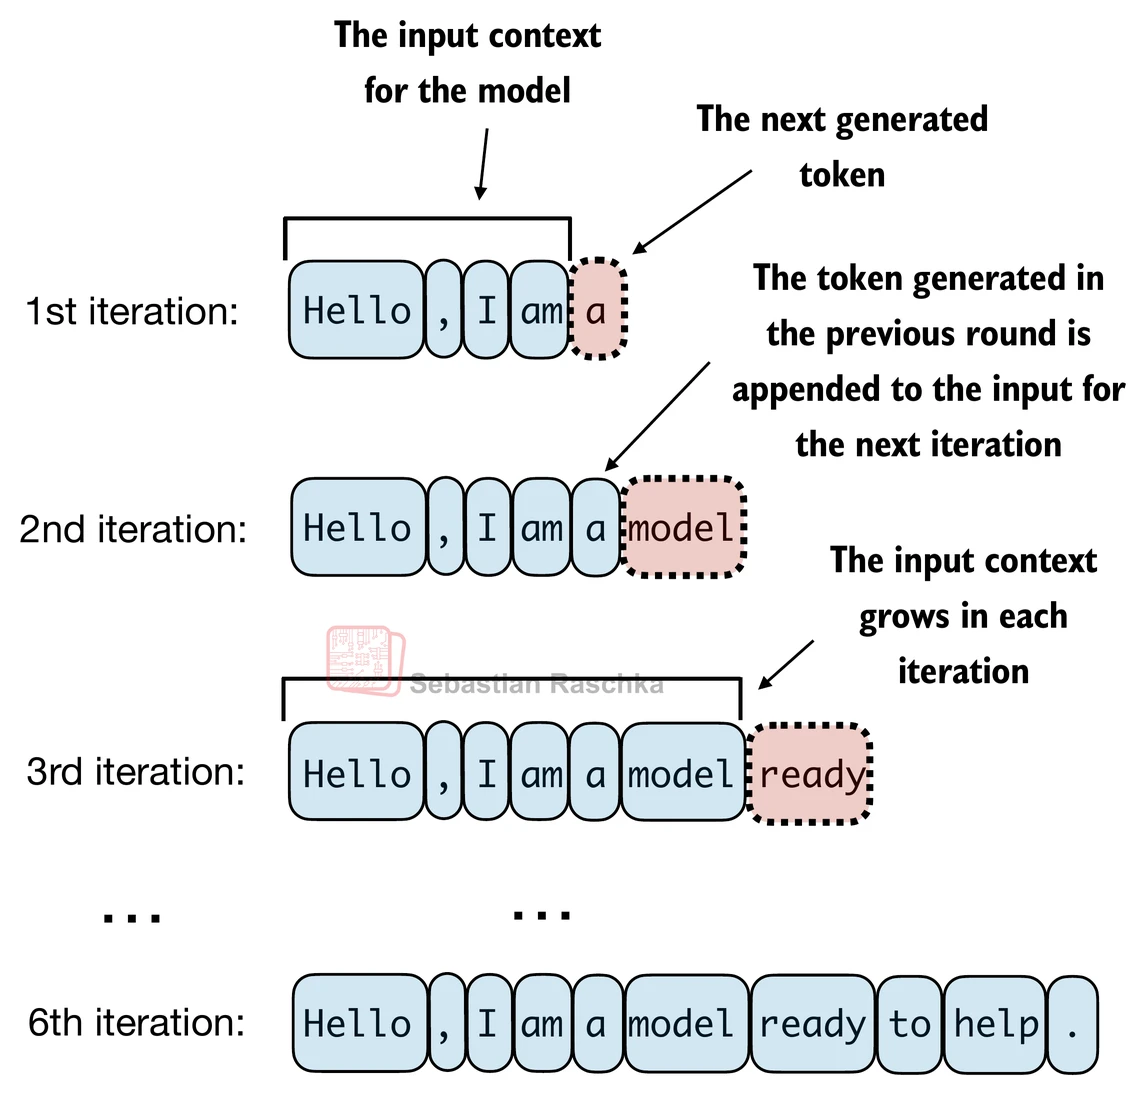

ilustra el proceso paso a paso mediante el cual un modelo GPT genera texto dado un contexto de entrada, como “Hello, I am”. Con cada iteración, el contexto de entrada crece, permitiendo que el modelo genere texto coherente y apropiado en contexto. Para la sexta iteración, el modelo ha construido una oración completa: “Hello, I am a model ready to help.”

Hemos visto que nuestra implementación actual de GPTModel produce tensores con la forma [batch_size, num_token, vocab_size]. Ahora la pregunta es: ¿cómo pasa un modelo GPT de estos tensores de salida al texto generado?
El proceso por el cual un modelo GPT convierte tensores de salida en texto generado involucra varios pasos. Estos pasos incluyen decodificar los tensores de salida, seleccionar tokens basados en una distribución de probabilidad y convertir esos tokens en texto legible por humanos.



El proceso de generación del siguiente token, ilustra un solo paso en el que el modelo GPT genera el siguiente token dado su entrada. En cada paso, el modelo produce una matriz con vectores que representan los posibles tokens siguientes. El vector correspondiente al siguiente token se extrae y se convierte en una distribución de probabilidad mediante la función softmax. Dentro del vector que contiene los puntajes de probabilidad resultantes, se localiza el índice con el valor más alto, lo que se traduce en el ID del token. Este ID de token se decodifica nuevamente en texto, produciendo el siguiente token en la secuencia. Finalmente, este token se agrega a las entradas anteriores, formando una nueva secuencia de entrada para la siguiente iteración.
Este proceso paso a paso permite que el modelo genere texto de manera secuencial, construyendo frases y oraciones coherentes a partir del contexto inicial de entrada.










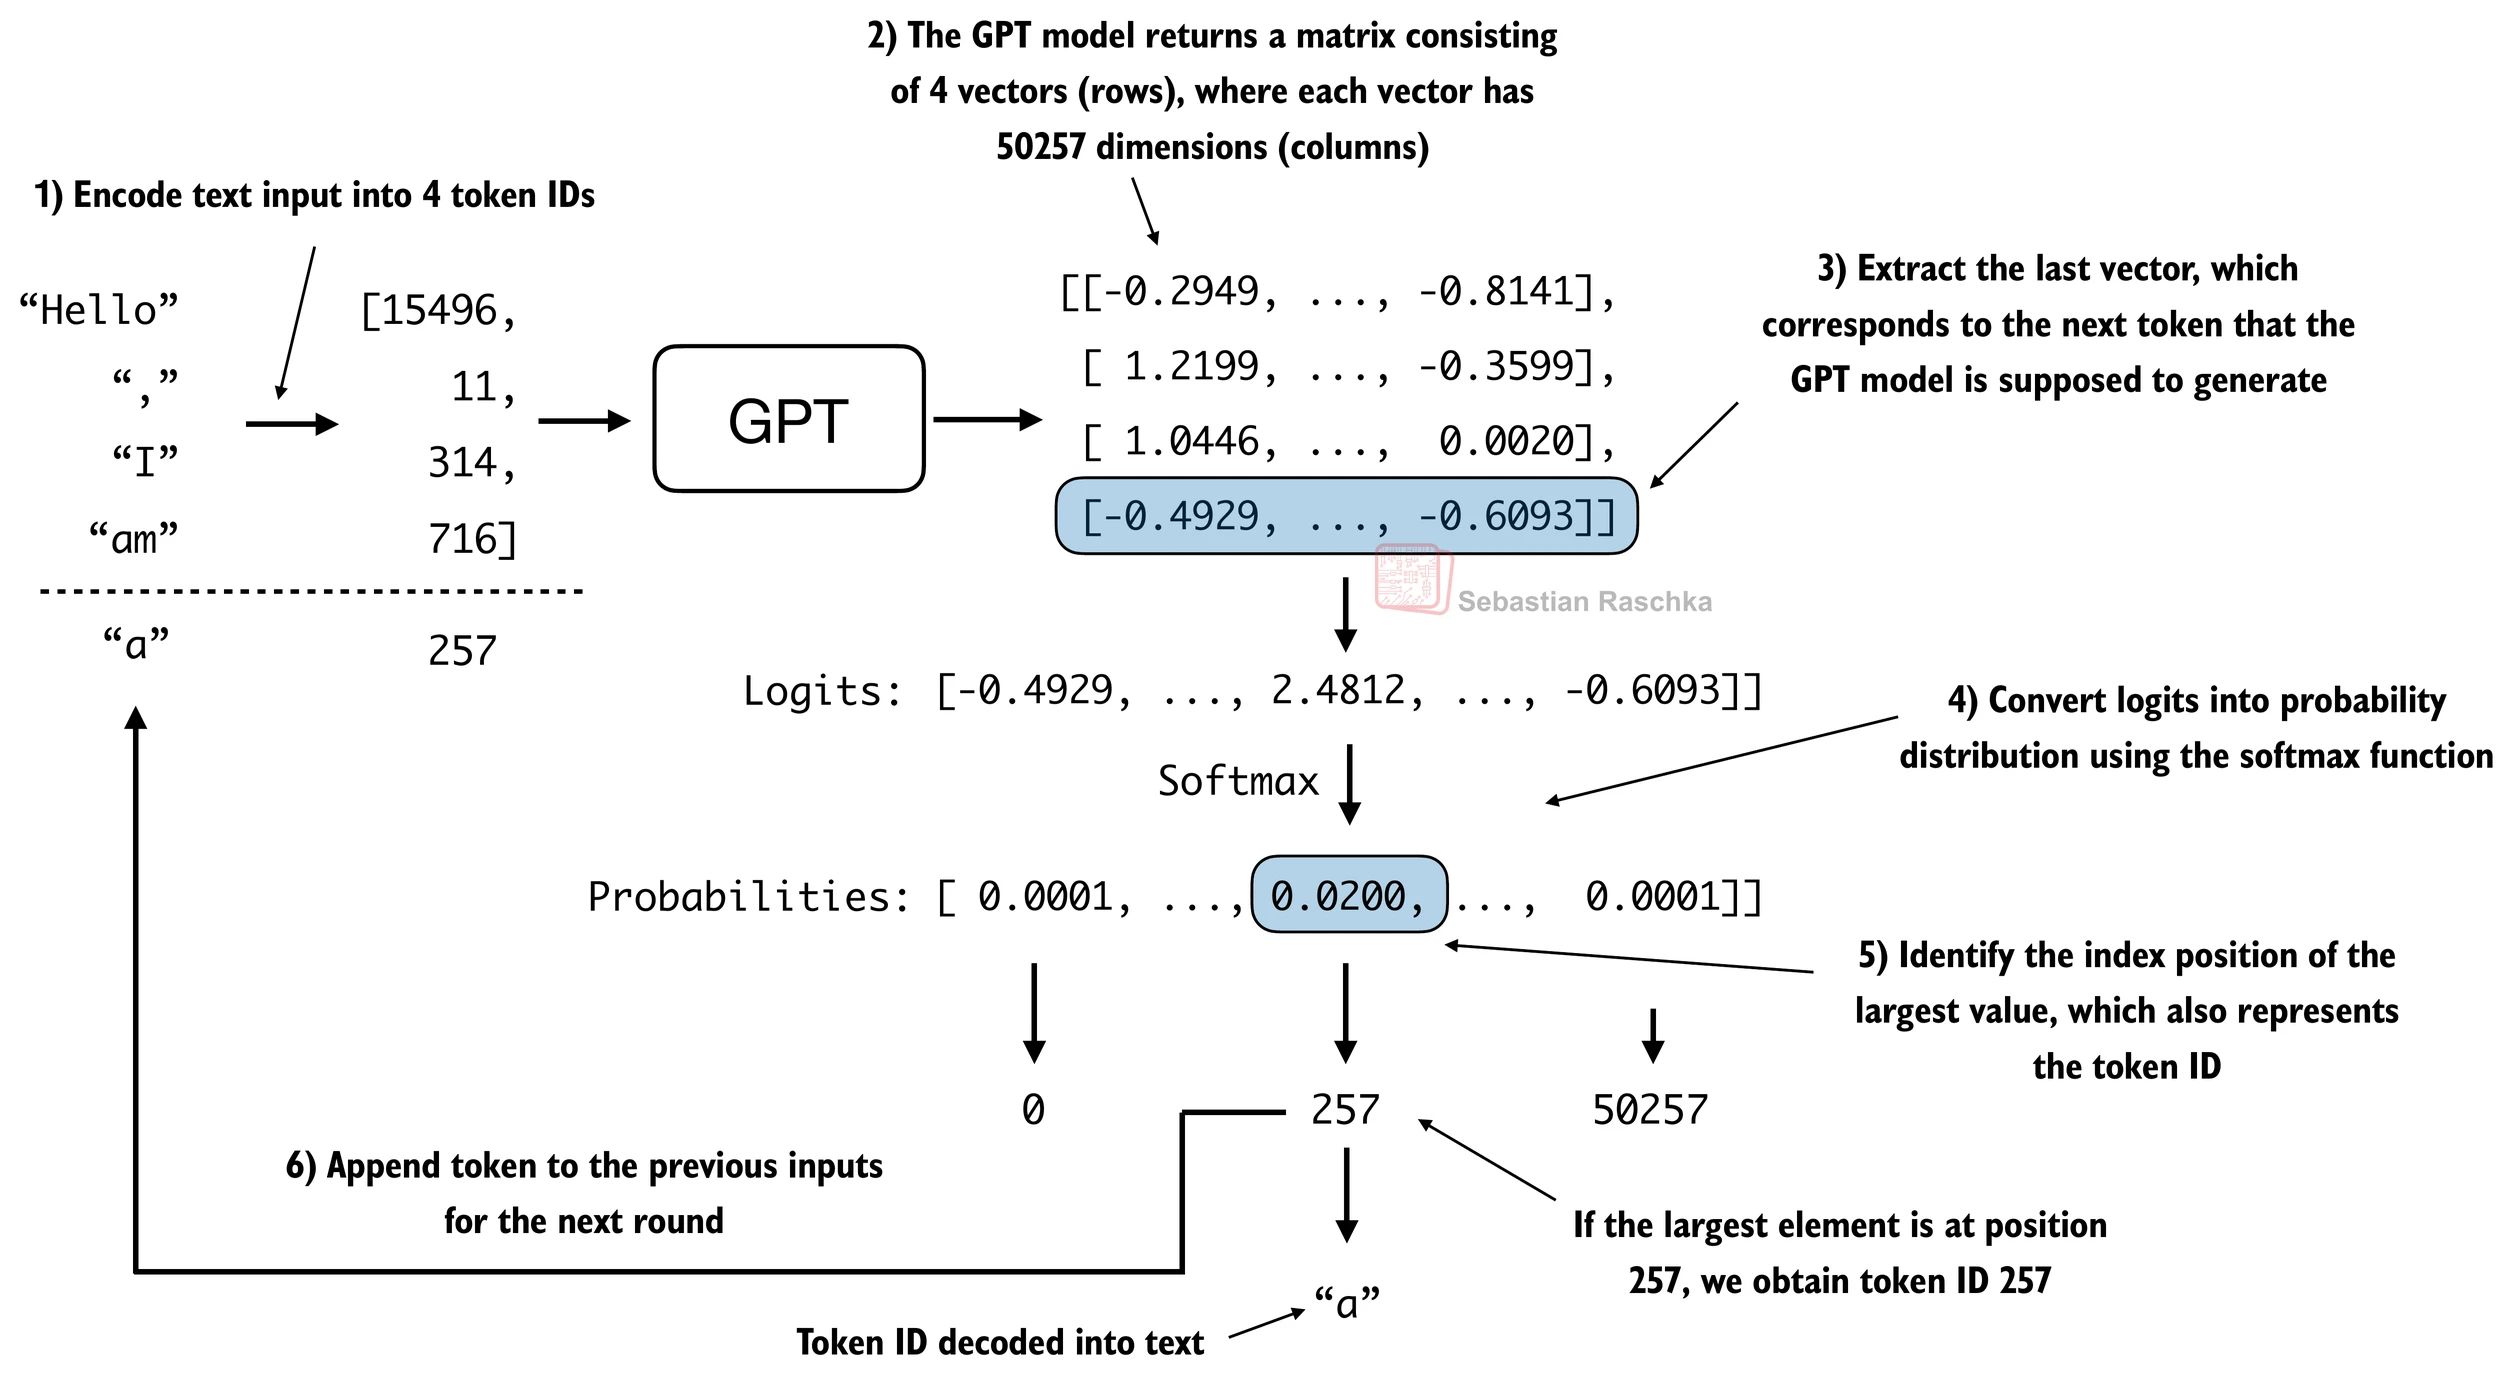

In [132]:
# función para que el modelo GPT genere texto.

def generate_text_simple(model, idx, max_new_tokens, context_size): # idx es un arreglo de índices con forma (batch, n_tokens) que representa los tokens en el contexto actual.

  for _ in range(max_new_tokens):
    idx_cond = idx[:, -context_size:]
    """
    Recorta el contexto actual si excede el tamaño de contexto soportado.
    Por ejemplo, si el LLM solo admite 5 tokens y el tamaño del contexto es 10,
    entonces solo se utilizan los últimos 5 tokens como contexto.
    """
    with torch.no_grad():
      logits = model(idx_cond)

    logits = logits[:, -1, :]       #Se enfoca únicamente en el último paso temporal, de modo que la forma (batch,n_token,vocab_size) se convierte en (batch,vocab_size).
    probas = torch.softmax(logits, dim=-1)               # probas tiene la forma (batch, vocab_size), el número de secuencias procesadas en paralelo el tamaño del vocabulario del modelo, que corresponde a la cantidad de tokens posibles.

    idx_next = torch.argmax(probas,dim=-1,keepdim=True)  # idx_next tiene la forma (batch, 1), es decir: batch → el número de secuencias que se están generando en paralelo. - 1 → representa que en cada paso se añade un único token nuevo por secuencia.

    idx = torch.cat((idx, idx_next), dim=1)  # Agrega el índice muestreado a la secuencia en curso, donde idx tiene la forma (batch, n_tokens+1).

  return idx


In [145]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


Para programar la función generate_text_simple, usamos una función softmax para convertir los logits en una distribución de probabilidad, a partir de la cual identificamos la posición con el valor más alto mediante torch.argmax. La función softmax es monótona, lo que significa que preserva el orden de sus entradas cuando se transforman en salidas. Por lo tanto, en la práctica, el paso de softmax es redundante, ya que la posición con la puntuación más alta en el tensor de salida de softmax es la misma posición en el tensor de logits. En otras palabras, se puede aplicar directamente la función torch.argmax al tensor de logits y obtener resultados idénticos. Sin embargo, proporciona el código de la conversión para ilustrar el proceso completo de transformar logits en probabilidades, para que el modelo genere el siguiente token más probable, lo que se conoce como **greedy decoding**.


Las seis iteraciones de un ciclo de predicción de tokens, donde el modelo toma una secuencia de IDs de tokens iniciales como entrada, predice el siguiente token y lo añade a la secuencia de entrada para la siguiente iteración. (Los IDs de tokens también se traducen a su texto correspondiente para una mejor comprensión).

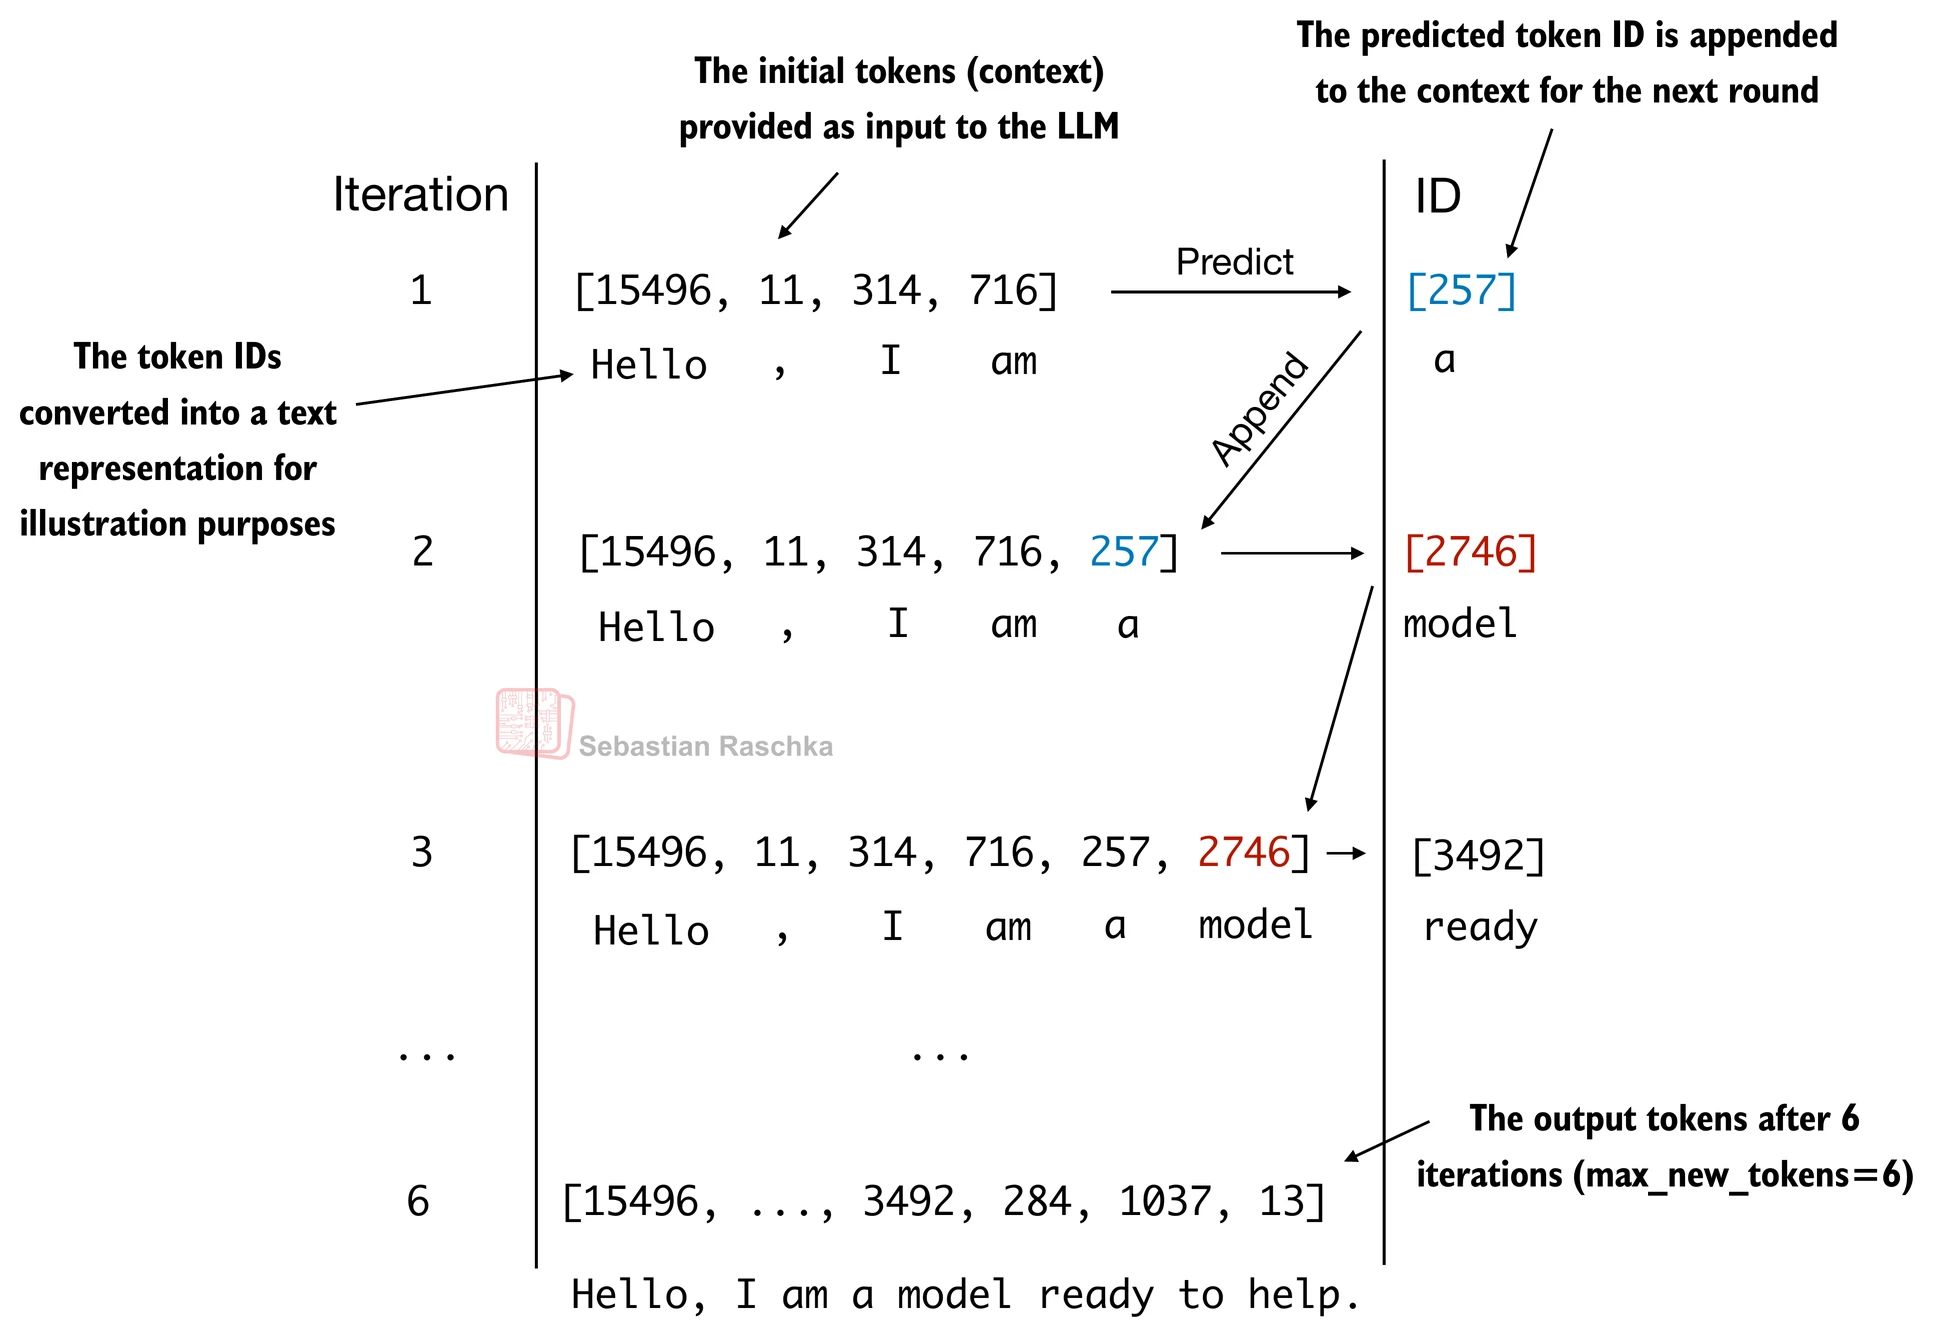

In [146]:
model.eval()
out = generate_text_simple(model = model,
                           idx = encoded_tensor,
                           max_new_tokens=6,
                           context_size=GPT_CONFIG_124M["context_length"]
)

print("Output: ", out)
print("Output length: ", len(out[0]))

Output:  tensor([[15496,    11,   314,   716,  5320,  2678,  8152, 22295, 42251,  5128]])
Output length:  10


In [147]:
decode_text = tokenizer.decode(out.squeeze(0).tolist())
print(decode_text)

Hello, I am"> countries Cry voluntarily roofs input


Como podemos ver, el modelo generó incoherencias, lo cual no se parece en nada a un texto coherente.
Hello, I am a model ready to help. ¿Qué ocurrió? La razón por la que el modelo no puede producir texto coherente es que aún no lo hemos entrenado.


In [148]:
import math
import torch
import torch.nn as nn

# =========================
# 1) CONFIG con 3 dropouts
# =========================
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,   # (opcional) compatibilidad hacia atrás
    "qkv_bias": True,

    # ✅ NUEVO: dropouts separados (Ejercicio 4.3)
    "drop_emb": 0.10,   # dropout en embeddings
    "drop_resid": 0.10, # dropout en shortcuts/residual
    "drop_attn": 0.10,  # dropout en pesos de atención
}


# =========================
# 2) Bloques básicos
# =========================
class LayerNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        # x: (B, T, C)
        mean = x.mean(dim=-1, keepdim=True)
        var  = x.var(dim=-1, keepdim=True, unbiased=False)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * x_hat + self.shift


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        emb = cfg["emb_dim"]
        self.net = nn.Sequential(
            nn.Linear(emb, 4 * emb),
            nn.GELU(),                 # estable (evita NaNs típicos de GELU casera)
            nn.Linear(4 * emb, emb),
        )

    def forward(self, x):
        return self.net(x)


# =========================
# 3) Multi-Head Attention
#    (dropout separado: drop_attn)
# =========================
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out debe ser divisible por num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout  = nn.Dropout(dropout)

        # máscara causal (1 arriba diagonal)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        # x: (B, T, C)
        b, num_tokens, d_in = x.shape

        keys    = self.W_key(x)    # (B, T, d_out)
        queries = self.W_query(x)
        values  = self.W_value(x)

        # (B, T, d_out) -> (B, T, H, D)
        keys    = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values  = values.view(b, num_tokens, self.num_heads, self.head_dim)

        # (B, T, H, D) -> (B, H, T, D)
        keys    = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values  = values.transpose(1, 2)

        # scores: (B, H, T, T)
        attn_scores = queries @ keys.transpose(2, 3)

        # máscara causal recortada
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        # más estable que -inf (evita NaNs en algunos dtypes)
        attn_scores = attn_scores.masked_fill(mask_bool, torch.finfo(attn_scores.dtype).min)

        attn_weights = torch.softmax(attn_scores / math.sqrt(self.head_dim), dim=-1)
        attn_weights = self.dropout(attn_weights)  # ✅ dropout de atención

        # (B, H, T, D) -> (B, T, H, D) -> (B, T, d_out)
        context = (attn_weights @ values).transpose(1, 2).contiguous()
        context = context.view(b, num_tokens, self.d_out)

        return self.out_proj(context)


# =========================
# 4) TransformerBlock
#    (dropout separado: drop_resid)
# =========================
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # fallback por si no existen (compatibilidad)
        drop_attn  = cfg.get("drop_attn", cfg["drop_rate"])
        drop_resid = cfg.get("drop_resid", cfg["drop_rate"])

        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=drop_attn,              # ✅ dropout atención
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )

        self.ff = FeedForward(cfg)

        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])

        self.drop_shortcut = nn.Dropout(drop_resid)  # ✅ dropout residual

    def forward(self, x):
        # Attention + residual
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        # FFN + residual
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


# =========================
# 5) GPTModel
#    (dropout separado: drop_emb)
# =========================
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        drop_emb = cfg.get("drop_emb", cfg["drop_rate"])

        self.tok_emb  = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb  = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(drop_emb)  # ✅ dropout embeddings

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        # in_idx: (B, T)
        b, seq_len = in_idx.shape

        tok = self.tok_emb(in_idx)  # (B, T, C)
        pos = self.pos_emb(torch.arange(seq_len, device=in_idx.device))  # (T, C)

        x = tok + pos
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)   # (B, T, vocab)
        return logits


# =========================
# 6) (Opcional) Generación greedy simple
# =========================
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits_last = logits[:, -1, :]  # (B, vocab)
        next_id = torch.argmax(logits_last, dim=-1, keepdim=True)  # (B, 1)
        idx = torch.cat((idx, next_id), dim=1)

    return idx


# =========================
# 7) TEST: que funcione
# =========================
torch.manual_seed(123)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = GPTModel(GPT_CONFIG_124M).to(device)

# ejemplo de batch de tokens (B=2, T=4)
batch = torch.tensor([[10, 11, 12, 13],
                      [20, 21, 22, 23]], device=device)

# forward
model.train()  # dropout activo (para ver que "funciona")
out = model(batch)

print("Input batch shape:", batch.shape)
print("Logits shape:", out.shape)

# verifica que realmente usa los 3 dropouts
print("drop_emb:", model.drop_emb.p)
print("drop_resid (block0):", model.trf_blocks[0].drop_shortcut.p)
print("drop_attn  (block0):", model.trf_blocks[0].att.dropout.p)

# generación (en eval se apaga dropout)
model.eval()
start = torch.tensor([[15496, 11, 314, 716]], device=device)  # ejemplo cualquiera
gen = generate_text_simple(model, start, max_new_tokens=6, context_size=GPT_CONFIG_124M["context_length"])
print("Generated ids:", gen)
print("Generated length:", gen.shape[1])


Input batch shape: torch.Size([2, 4])
Logits shape: torch.Size([2, 4, 50257])
drop_emb: 0.1
drop_resid (block0): 0.1
drop_attn  (block0): 0.1
Generated ids: tensor([[15496,    11,   314,   716,  3127, 29991,  6539, 21826, 18530,  6276]])
Generated length: 10


Resumen
- Normalización de capas: estabiliza el entrenamiento asegurando que las salidas de cada capa tengan una media y varianza consistentes.
- Conexiones de atajo: son conexiones que saltan una o más capas alimentando la salida de una capa directamente a una capa más profunda, lo que ayuda a mitigar el problema del gradiente desvanecido al entrenar redes neuronales profundas, como los LLMs.
- Bloques Transformer: son un componente estructural central de los modelos GPT, combinando módulos de atención enmascarada multi-cabeza con redes feed forward totalmente conectadas que utilizan la función de activación GELU.
- Modelos GPT: son LLMs con muchos bloques Transformer repetidos que contienen millones a miles de millones de parámetros.
- Tamaños de modelos GPT: existen en varias escalas, por ejemplo, 124, 345, 762 y 1.542 millones de parámetros, los cuales podemos implementar con la misma clase GPTModel en Python.
- Capacidad de generación de texto: un LLM tipo GPT genera texto humano-decible decodificando tensores de salida al predecir secuencialmente un token a la vez, basado en un contexto de entrada dado.
- Entrenamiento necesario: sin entrenamiento, un modelo GPT produce texto incoherente, lo que subraya la importancia del entrenamiento para lograr generación de texto coherente.
